## 딥러닝응용 1주차 리포트
### 2. 동일한 데이터로 딥러닝 분류 수행하라. (dense layer 만 사용)

In [20]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
# Load Data
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [22]:
# Create Target
x = df.drop(['Outcome'], axis=1)
y = df['Outcome']

In [23]:
# Train-Test Split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [24]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Data
df = pd.read_csv('diabetes.csv')
x = df.drop(['Outcome'], axis=1).values
y = df['Outcome'].values

# Train-Test Split + Data Normalization
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert to PyTorch Tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataset and DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [25]:
# NeuralNetwork Class 
class NeuralNetwork(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(n_hidden, n_hidden)
        self.l3 = nn.Linear(n_hidden, n_output)


    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        return x

# Hyperparameters
n_input = x_train.shape[1]   
n_output = 2            
n_hidden = 64                

# Functions
model = NeuralNetwork(n_input, n_output, n_hidden).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train Function
def train(dataloader, model, loss_fn, optimizer):
    model.train() 
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Test Function
def test(dataloader, model, loss_fn):
    model.eval()  
    test_loss, correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad(): 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            # Store predictions and true labels for later analysis
            all_preds.append(pred.argmax(1).cpu().numpy())
            all_labels.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels, test_loss / len(dataloader), correct / len(dataloader.dataset)


# Train + Test Loop
epochs = 20
for t in range(epochs):
    print(f"Epoch [{t+1}/{epochs}] ---------------------------")
    train(train_loader, model, loss_fn, optimizer)
    y_pred, y_true, avg_loss, accuracy = test(test_loader, model, loss_fn)
    print(f"Test Accuracy: {100 * accuracy:.2f}%, Avg loss: {avg_loss:.6f}")

Epoch [1/20] ---------------------------
Test Accuracy: 76.62%, Avg loss: 0.543098
Epoch [2/20] ---------------------------
Test Accuracy: 75.32%, Avg loss: 0.519903
Epoch [3/20] ---------------------------
Test Accuracy: 77.92%, Avg loss: 0.499443
Epoch [4/20] ---------------------------
Test Accuracy: 77.92%, Avg loss: 0.504042
Epoch [5/20] ---------------------------
Test Accuracy: 73.38%, Avg loss: 0.521772
Epoch [6/20] ---------------------------
Test Accuracy: 77.92%, Avg loss: 0.502796
Epoch [7/20] ---------------------------
Test Accuracy: 75.32%, Avg loss: 0.510700
Epoch [8/20] ---------------------------
Test Accuracy: 77.92%, Avg loss: 0.504707
Epoch [9/20] ---------------------------
Test Accuracy: 76.62%, Avg loss: 0.514849
Epoch [10/20] ---------------------------
Test Accuracy: 75.97%, Avg loss: 0.515531
Epoch [11/20] ---------------------------
Test Accuracy: 76.62%, Avg loss: 0.521980
Epoch [12/20] ---------------------------
Test Accuracy: 77.27%, Avg loss: 0.516702
E

Neural Network Classification Report (Original Labels)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        99
           1       0.62      0.65      0.64        55

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.73      0.74       154



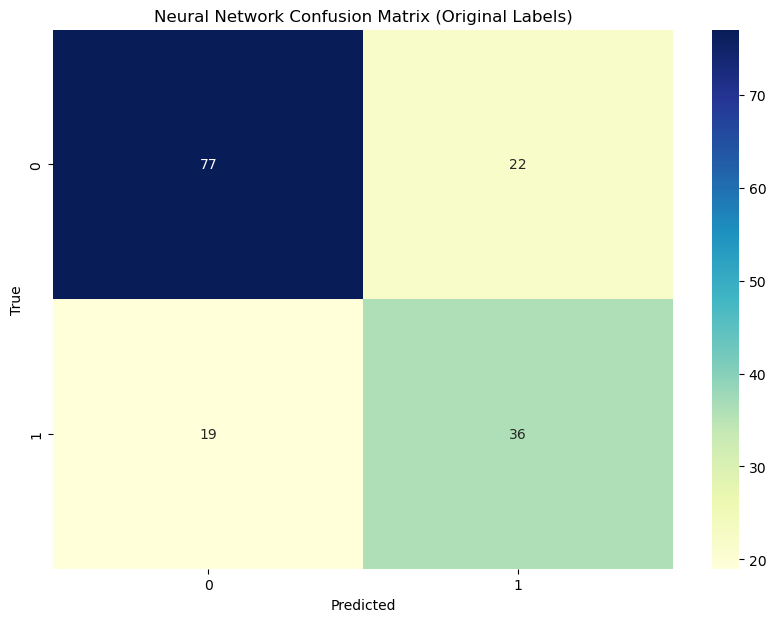

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

# Classification Report and Confusion Matrix 
print("Neural Network Classification Report (Original Labels)")
print(classification_report(y_true, y_pred, zero_division=0))

cm = confusion_matrix(y_true, y_pred)

unique_labels = sorted(set(y_test) | set(y_pred))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Neural Network Confusion Matrix (Original Labels)')
plt.show()